In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy import stats
from google.colab import files


try:
    # Load the dataset
    file_path = '/content/Metro_Interstate_Traffic_Volume.csv'
    data = pd.read_csv(file_path)

    # Convert date_time to datetime format for potential time series analysis
    data['date_time'] = pd.to_datetime(data['date_time'])

    # Rename Columns for clarity
    data.rename(columns={
        'temp': 'temperature_kelvin',
        'rain_1h': 'rain_mm_per_hour',
        'snow_1h': 'snow_mm_per_hour',
        'clouds_all': 'cloud_coverage_percentage',
        'weather_main': 'weather_condition',
        'weather_description': 'detailed_weather_condition',
        'traffic_volume': 'traffic_volume'
    }, inplace=True)

    # Drop Duplicates
    data.drop_duplicates(inplace=True)

    data['temperature_fahrenheit'] = (data['temperature_kelvin'] - 273.15) * 9/5 + 32
    data.drop('temperature_kelvin', axis=1, inplace=True)  # Remove the original Kelvin column if no longer needed


    # Extract Features from Timestamp
    data['hour'] = data['date_time'].dt.hour
    data['day_of_week'] = data['date_time'].dt.dayofweek
    data['month'] = data['date_time'].dt.month

    # New Category Features for EDA based on Fahrenheit
    data['temp_category'] = pd.cut(data['temperature_fahrenheit'], bins=[-np.inf, 32, 68, np.inf], labels=['cold', 'moderate', 'hot'])

    # Lag Features (for time series analysis, if applicable)
    data['traffic_volume_lag1'] = data['traffic_volume'].shift(1)

    # Mean Encoding Features (for categorical variables with respect to 'traffic_volume')
    mean_encoded_temp = data.groupby('temp_category')['traffic_volume'].mean().to_dict()
    data['temp_category_mean_encoded'] = data['temp_category'].map(mean_encoded_temp)

    # Find Outliers using Z-score for 'temperature_celsius' and 'traffic_volume'
    data = data[(np.abs(stats.zscore(data['temperature_fahrenheit'])) < 3)]
    data = data[(np.abs(stats.zscore(data['traffic_volume'])) < 3)]

    # Recheck Missing Values and fill or drop if necessary
    data.fillna(data.median(), inplace=True)  # Example: fill with median for numerical columns

    # Normalization using Min-Max Scaler (adjust for new or modified features as necessary)
    scaler = MinMaxScaler()
    numerical_columns = ['temperature_fahrenheit', 'rain_mm_per_hour', 'snow_mm_per_hour', 'cloud_coverage_percentage', 'traffic_volume', 'traffic_volume_lag1']
    data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

    # Save the cleaned and feature-engineered data to a new CSV file
    cleaned_file_path = '/content/cleaned_data_MSAAI_Final.csv'
    data.to_csv(cleaned_file_path, index=False)

    print("Cleaned and feature-engineered data saved to:", cleaned_file_path)
    # files.download('/content/cleaned_data_MSAAI_Final.csv')

except FileNotFoundError as e:
    print(f"File not found: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

<ipython-input-2-7198ff7a8025>:54: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data.fillna(data.median(), inplace=True)  # Example: fill with median for numerical columns
<ipython-input-2-7198ff7a8025>:54: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.median(), inplace=True)  # Example: fill with median for numerical columns


Cleaned and feature-engineered data saved to: /content/cleaned_data_MSAAI_Final.csv


       rain_mm_per_hour  snow_mm_per_hour  cloud_coverage_percentage  \
count      48177.000000      48177.000000               48177.000000   
mean           0.000034          0.000436                   0.493757   
std            0.004557          0.016019                   0.390128   
min            0.000000          0.000000                   0.000000   
25%            0.000000          0.000000                   0.010000   
50%            0.000000          0.000000                   0.640000   
75%            0.000000          0.000000                   0.900000   
max            1.000000          1.000000                   1.000000   

       traffic_volume  temperature_fahrenheit          hour   day_of_week  \
count    48177.000000            48177.000000  48177.000000  48177.000000   
mean         0.447805                0.567987     11.399049      2.984453   
std          0.272920                0.190610      6.940463      2.005945   
min          0.000000                0.0000

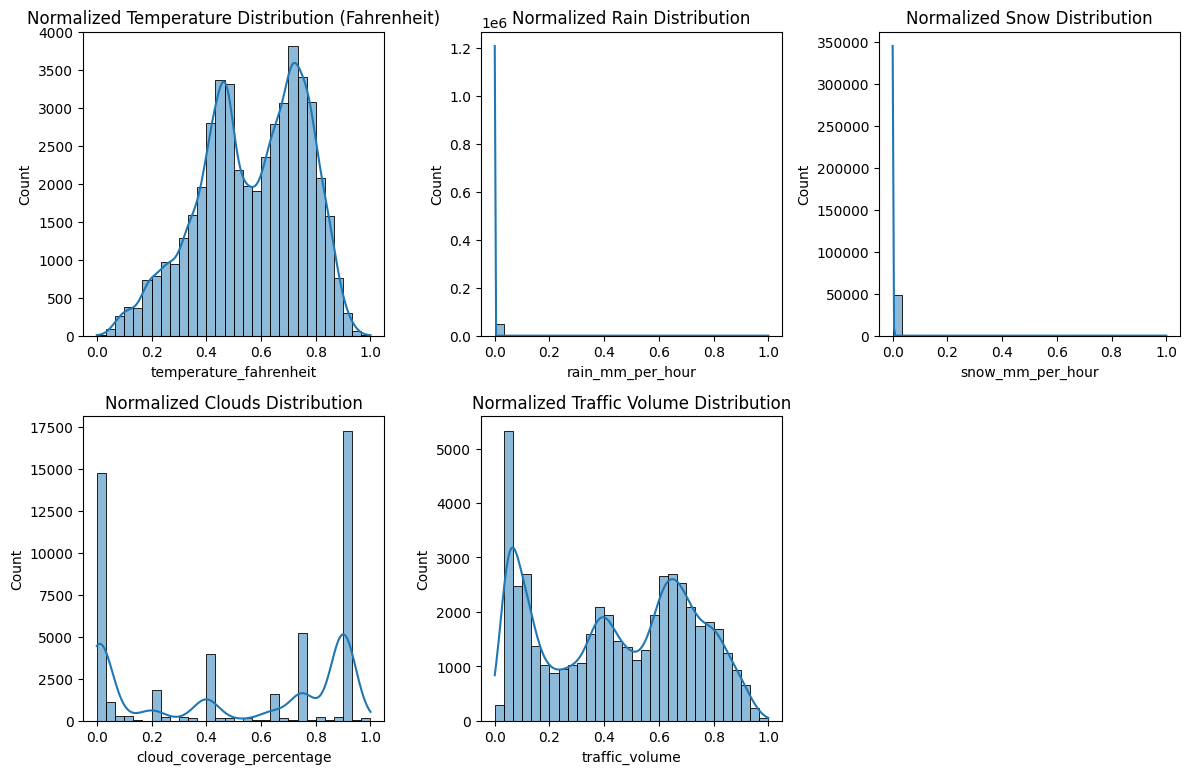

<ipython-input-3-9b1542de5756>:48: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")


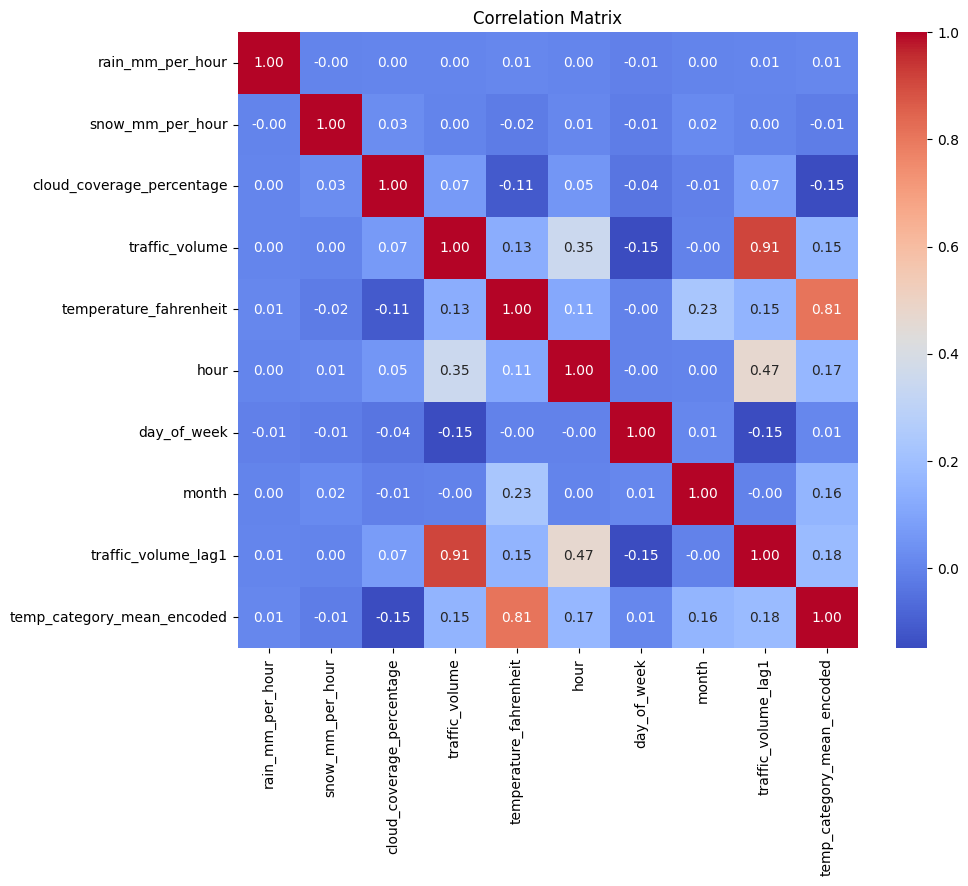

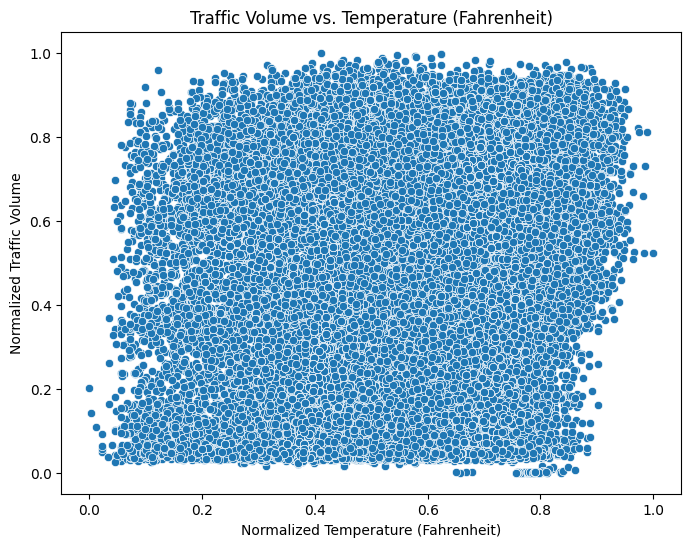

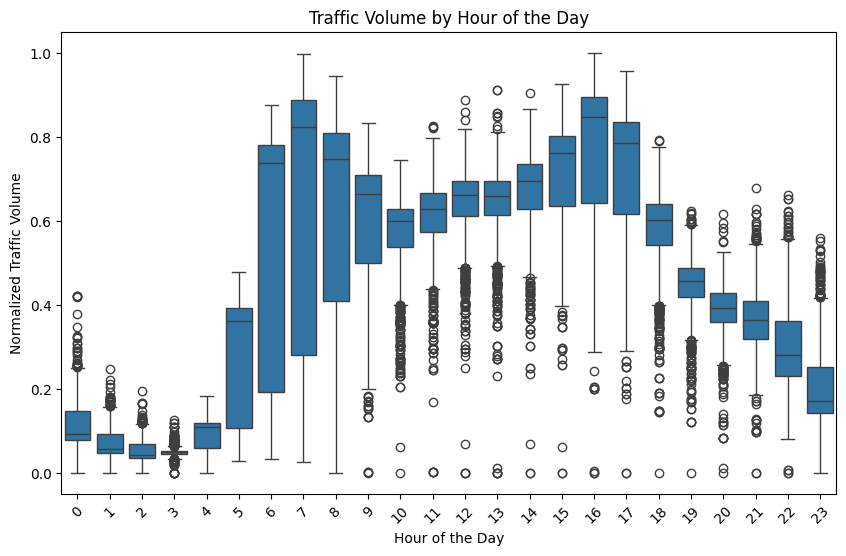

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned and normalized dataset
file_path = '/content/cleaned_data_MSAAI_Final.csv'  # Update with the correct path if needed
data = pd.read_csv(file_path)

# Convert 'date_time' back to datetime format if necessary
data['date_time'] = pd.to_datetime(data['date_time'])

# Summary statistics
print(data.describe())

# Visualizing distributions of variables
plt.figure(figsize=(12, 8))

# Temperature distribution (now using Fahrenheit)
plt.subplot(2, 3, 1)
sns.histplot(data['temperature_fahrenheit'], bins=30, kde=True)
plt.title('Normalized Temperature Distribution (Fahrenheit)')

# Rain distribution
plt.subplot(2, 3, 2)
sns.histplot(data['rain_mm_per_hour'], bins=30, kde=True)
plt.title('Normalized Rain Distribution')

# Snow distribution
plt.subplot(2, 3, 3)
sns.histplot(data['snow_mm_per_hour'], bins=30, kde=True)
plt.title('Normalized Snow Distribution')

# Clouds distribution
plt.subplot(2, 3, 4)
sns.histplot(data['cloud_coverage_percentage'], bins=30, kde=True)
plt.title('Normalized Clouds Distribution')

# Traffic Volume distribution
plt.subplot(2, 3, 5)
sns.histplot(data['traffic_volume'], bins=30, kde=True)
plt.title('Normalized Traffic Volume Distribution')

plt.tight_layout()
plt.show()

# Examining relationships using scatter plots and correlation matrices
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Optional: Scatter plot example (Traffic Volume vs. Temperature)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['temperature_fahrenheit'], y=data['traffic_volume'])
plt.title('Traffic Volume vs. Temperature (Fahrenheit)')
plt.xlabel('Normalized Temperature (Fahrenheit)')
plt.ylabel('Normalized Traffic Volume')
plt.show()

# Investigating temporal patterns (if needed, aggregate data by hour, day, month, etc.)
data['hour'] = data['date_time'].dt.hour
plt.figure(figsize=(10, 6))
sns.boxplot(x='hour', y='traffic_volume', data=data)
plt.title('Traffic Volume by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Normalized Traffic Volume')
plt.xticks(rotation=45)
plt.show()

In [4]:
import datetime as dt
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from random import choice, randint
import scipy.stats as scs
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.validation import check_is_fitted
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, Flatten, TimeDistributed, MaxPooling1D, Activation
from tensorflow.keras.models import Sequential
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [5]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.utils import pad_sequences

In [6]:

#loading data into pandas dataframe
df = pd.read_csv('/content/cleaned_data_MSAAI_Final.csv')

#training and validation sets
# assigning size for data subset
subset_size = int(len(df)*0.01)

# taking random data subset
df_subset = df.sample(subset_size, random_state=1)

#spliting data subset 80/20 for train/validation
train_df = df_subset.sample(frac=0.8, random_state=1)
val_df = df_subset.drop(train_df.index)

In [7]:
#reseting the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [8]:
# Initialize empty lists for sequences and their corresponding labels
seq_arrays = []
seq_labs = []

# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['temperature_fahrenheit', 'rain_mm_per_hour', 'snow_mm_per_hour', 'cloud_coverage_percentage', 'traffic_volume', 'traffic_volume_lag1']
    # Add any other preprocessed features here
#Create list of sequence length GAP readings
for i in range(seq_length, len(train_df)-ph):
    # Create a sequence of length seq_length
    seq = []
    for col in feat_cols:
        seq.append(train_df.loc[i-seq_length:i-1, col].values)
    seq = np.stack(seq, axis=1)
    seq_arrays.append(seq)

    # Get the corresponding label (GAP measurement at predictive horizon)
    label = train_df.loc[i+ph, 'traffic_volume']
    seq_labs.append(label)

# Convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype=np.float32)
seq_labs = np.array(seq_labs, dtype=np.float32)

In [9]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [10]:
seq_arrays.shape

(350, 30, 6)

In [11]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = seq_arrays.shape[2]
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=30, #number of hidden units
         return_sequences=True))
model.add(Dropout(0.2))

# add second LSTM layer
model.add(LSTM(
          units=15,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            4440      
                                                                 
 dropout (Dropout)           (None, 30, 30)            0         
                                                                 
 lstm_1 (LSTM)               (None, 15)                2760      
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 7216 (28.19 KB)
Trainable params: 7216 (28

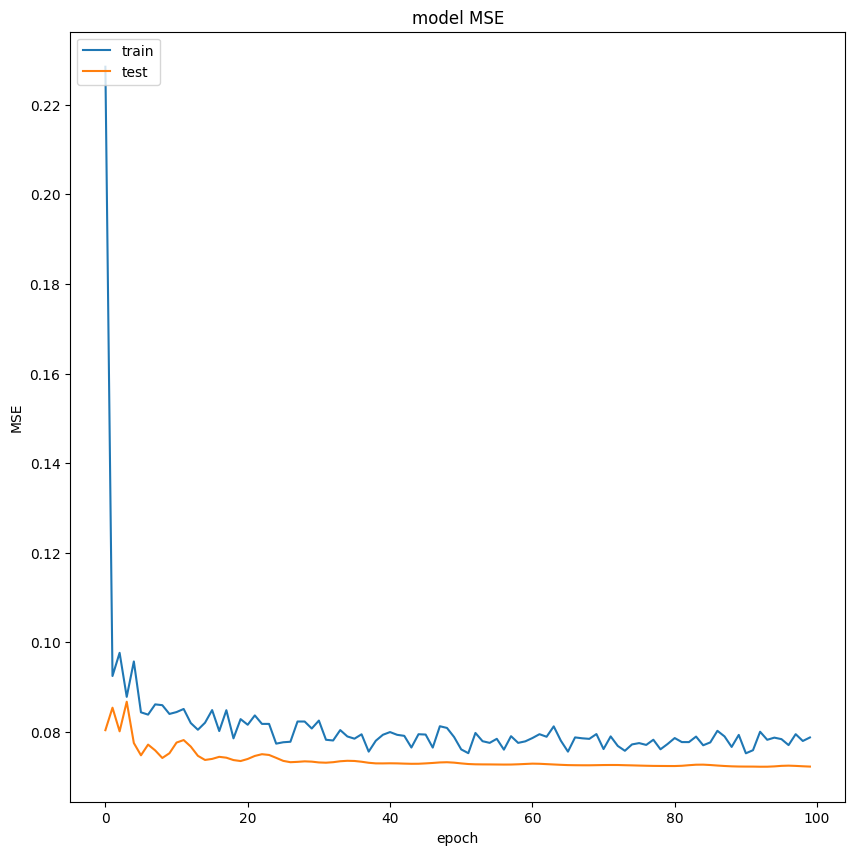

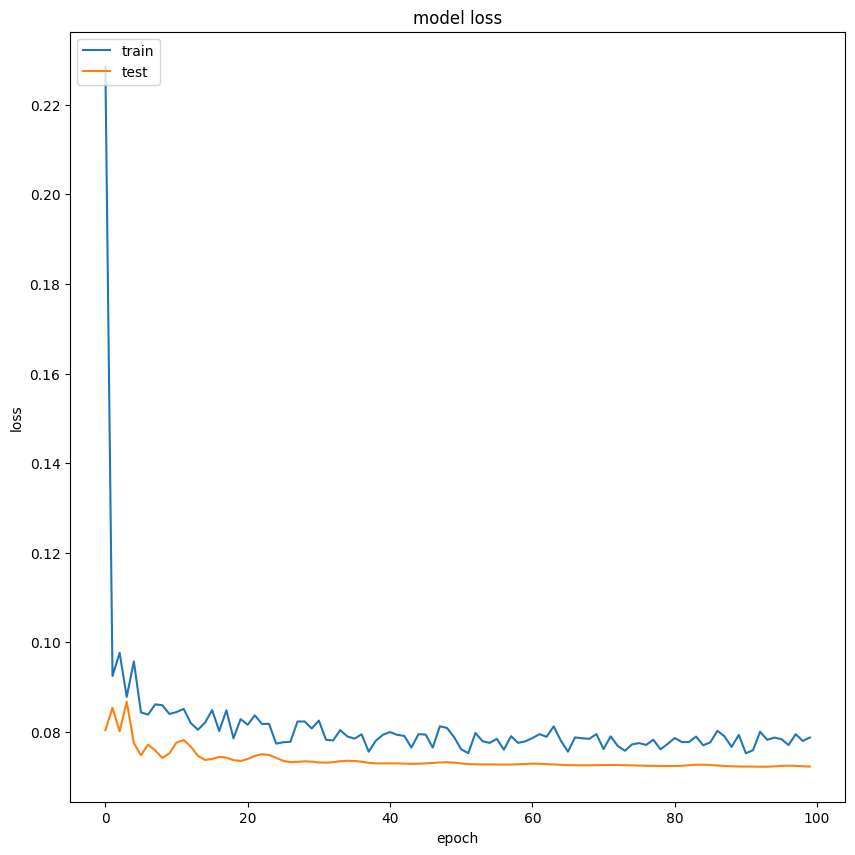

In [12]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

In [13]:
val_arrays = []
val_labs = []

# create list of GAP readings starting with a minimum of two readings
for i in range(seq_length, len(val_df)-ph):
    seq = val_df[feat_cols].iloc[i-seq_length:i].to_numpy()
    val_arrays.append(seq)
    val_labs.append(val_df[feat_cols].iloc[i+ph]['traffic_volume'])

# use the pad_sequences function on your input sequences
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype=np.float32, padding='post', truncating='post')

# convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [14]:
print(val_arrays.shape)

(61, 30, 6)


2/2 - 0s - loss: 0.0659 - mse: 0.0659 - 33ms/epoch - 16ms/step

MSE: 0.06585216522216797
2/2 [==============================] - 1s 14ms/step


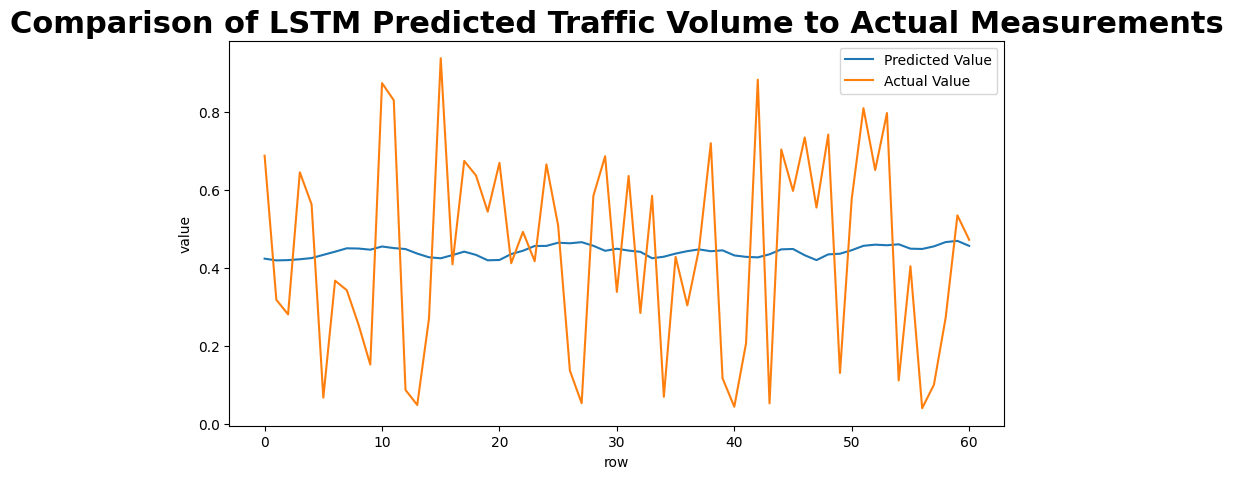

In [15]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Comparison of LSTM Predicted Traffic Volume to Actual Measurements', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

In [16]:
#Data loading data
df = pd.read_csv('/content/cleaned_data_MSAAI_Final.csv')

####### training and validation sets #########
# assigning size for data subset
subset_size = int(len(df)*0.04)

# taking random data subset
df_subset = df.sample(subset_size, random_state=1)

#spliting data subset 80/20 for train/validation
train_df = df_subset.sample(frac=0.8, random_state=1)
val_df = df_subset.drop(train_df.index)

#reseting the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [17]:
# Initialize empty lists for sequences and their corresponding labels
seq_arrays = []
seq_labs = []

# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['temperature_fahrenheit', 'rain_mm_per_hour', 'snow_mm_per_hour', 'cloud_coverage_percentage', 'traffic_volume', 'traffic_volume_lag1']

#Create list of sequence length GAP readings
for i in range(seq_length, len(train_df)-ph):
    # Create a sequence of length seq_length
    seq = []
    for col in feat_cols:
        seq.append(train_df.loc[i-seq_length:i-1, col].values)
    seq = np.stack(seq, axis=1)
    seq_arrays.append(seq)

    # Get the corresponding label (GAP measurement at predictive horizon)
    label = train_df.loc[i+ph, 'traffic_volume']
    seq_labs.append(label)

# Convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype=np.float32)
seq_labs = np.array(seq_labs, dtype=np.float32)


assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [18]:

fig_acc.savefig("LSTM_loss1.png")

In [19]:
!pip install pytorch-lightning torchmetrics -q

In [20]:
src_path = '/content/Metro_Interstate_Traffic_Volume.csv'

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
pd.options.mode.chained_assignment = None

In [22]:
import pandas as pd

# Assuming 'content' is a directory and 'src_path' is a variable containing the path to that directory
src_path = '/content/Metro_Interstate_Traffic_Volume.csv' # replace 'your_directory_path/' with the actual path to where 'content' directory is located

# Now read the CSV file
df = pd.read_csv(file_path, parse_dates=['date_time'], index_col='date_time')


In [23]:
df.head(5)

,holiday,rain_mm_per_hour,snow_mm_per_hour,cloud_coverage_percentage,weather_condition,detailed_weather_condition,traffic_volume,temperature_fahrenheit,hour,day_of_week,month,temp_category,traffic_volume_lag1,temp_category_mean_encoded
date_time,,,,,,,,,,,,,,
2012-10-02 09:00:00,None,0.0,0.0,0.40,Clouds,scattered clouds,0.761676,0.673215,9,1,10,moderate,0.464286,3196.570906
2012-10-02 10:00:00,None,0.0,0.0,0.75,Clouds,broken clouds,0.620330,0.689412,10,1,10,moderate,0.761676,3196.570906
2012-10-02 11:00:00,None,0.0,0.0,0.90,Clouds,overcast clouds,0.654808,0.692711,11,1,10,moderate,0.620330,3196.570906
2012-10-02 12:00:00,None,0.0,0.0,0.90,Clouds,overcast clouds,0.690385,0.700960,12,1,10,moderate,0.654808,3196.570906
2012-10-02 13:00:00,None,0.0,0.0,0.75,Clouds,broken clouds,0.675549,0.716107,13,1,10,moderate,0.690385,3196.570906


In [24]:
df.dtypes

holiday                        object
rain_mm_per_hour              float64
snow_mm_per_hour              float64
cloud_coverage_percentage     float64
weather_condition              object
detailed_weather_condition     object
traffic_volume                float64
temperature_fahrenheit        float64
hour                            int64
day_of_week                     int64
month                           int64
temp_category                  object
traffic_volume_lag1           float64
temp_category_mean_encoded    float64
dtype: object

In [25]:
df.shape

(48177, 14)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Clouds'),
  Text(1, 0, 'Clear'),
  Text(2, 0, 'Rain'),
  Text(3, 0, 'Drizzle'),
  Text(4, 0, 'Mist'),
  Text(5, 0, 'Haze'),
  Text(6, 0, 'Fog'),
  Text(7, 0, 'Thunderstorm'),
  Text(8, 0, 'Snow'),
  Text(9, 0, 'Squall'),
  Text(10, 0, 'Smoke')])

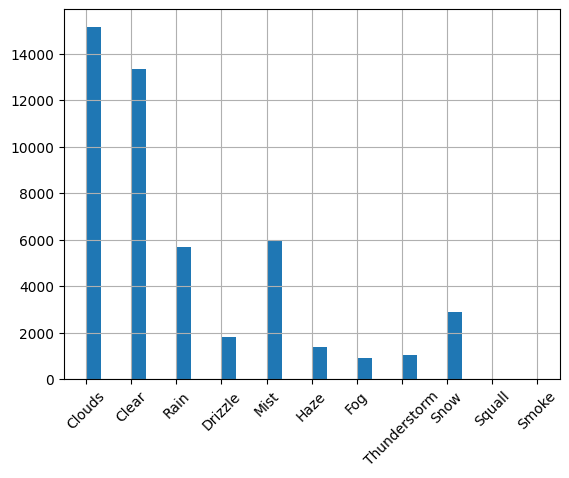

In [26]:
df['weather_condition'].hist(bins=30)
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'None'),
  Text(1, 0, 'Columbus Day'),
  Text(2, 0, 'Veterans Day'),
  Text(3, 0, 'Thanksgiving Day'),
  Text(4, 0, 'Christmas Day'),
  Text(5, 0, 'New Years Day'),
  Text(6, 0, 'Washingtons Birthday'),
  Text(7, 0, 'Memorial Day'),
  Text(8, 0, 'Independence Day'),
  Text(9, 0, 'State Fair'),
  Text(10, 0, 'Labor Day'),
  Text(11, 0, 'Martin Luther King Jr Day')])

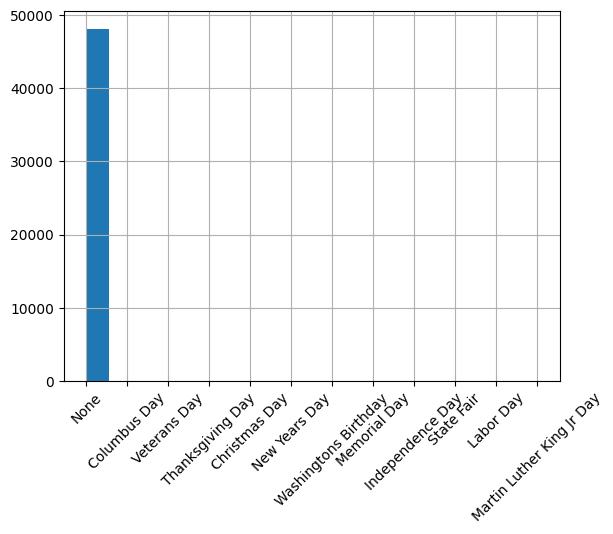

In [27]:
df['holiday'].hist(bins=20)
plt.xticks(rotation=45)

In [28]:
df[df.index.duplicated()].shape

(7612, 14)

In [29]:
df = df[~df.index.duplicated(keep='last')]

In [30]:
df.shape

(40565, 14)

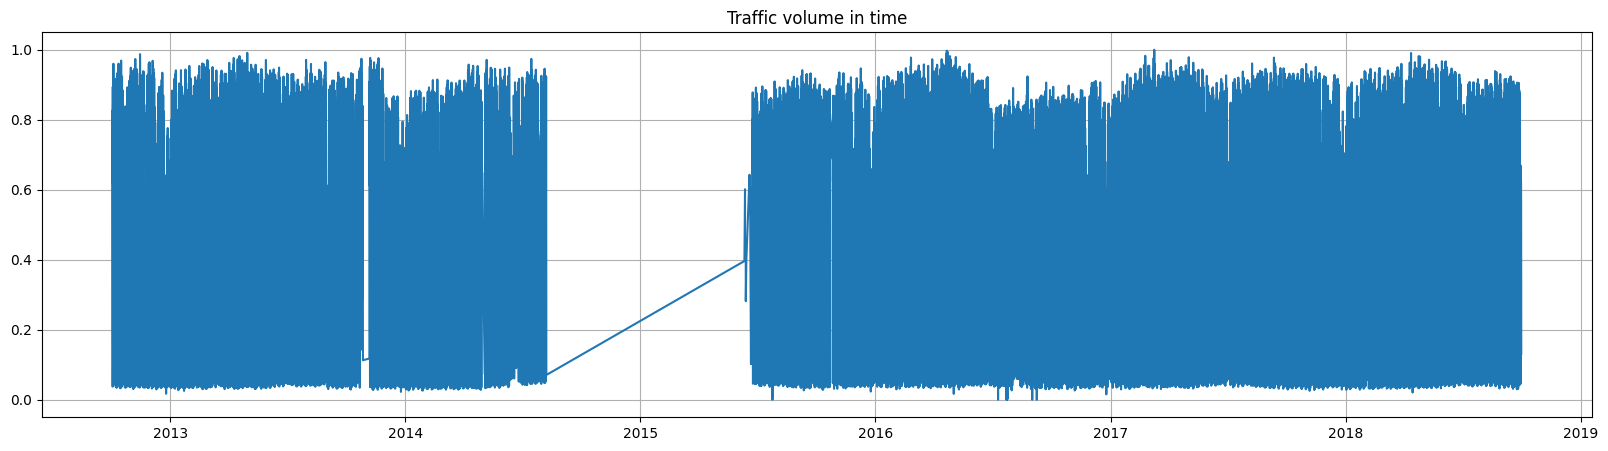

In [31]:
plt.figure(figsize=[20,5])
plt.title('Traffic volume in time')
plt.plot(df.index, df.traffic_volume)
plt.grid()

Values from mid 2014 to mid 2015 are missing, next steps will consider only data from 2015 mid and consequent.

In [32]:
date_range = pd.date_range('2012-10-02 09:00:00', '2018-09-30 23:00:00', freq='1H')

In [33]:
missing_hours = set(date_range) - set(df.index)

In [34]:
print(f'There is {len(missing_hours)} missing indexes from start to end timestamp.')

There is 11986 missing indexes from start to end timestamp.


In [35]:
df['temperature_fahrenheit'].describe()

count    40565.000000
mean         0.569801
std          0.196387
min          0.000000
25%          0.426665
50%          0.592007
75%          0.733203
max          1.000000
Name: temperature_fahrenheit, dtype: float64

<Axes: xlabel='date_time'>

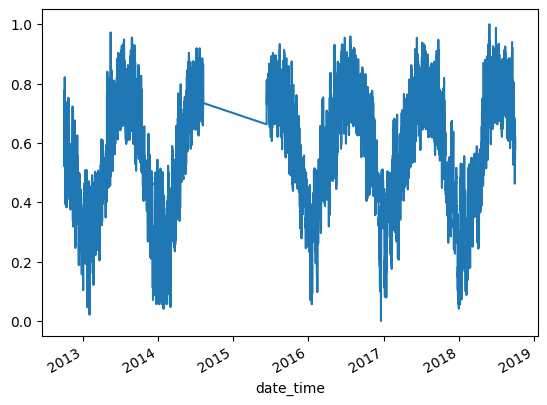

In [36]:
df['temperature_fahrenheit'].plot()

In [37]:
df['temperature_fahrenheit'] = df['temperature_fahrenheit'].replace(0, df['temperature_fahrenheit'].median())

In [38]:
df = df[df.index.year.isin([2016, 2017, 2018])].copy()

In [39]:
df = pd.concat([df.select_dtypes(include=['object']).fillna('backfill'),
                df.select_dtypes(include=['float', 'int']).interpolate()], axis=1)

In [40]:
df.head(5)

,holiday,weather_condition,detailed_weather_condition,temp_category,rain_mm_per_hour,snow_mm_per_hour,cloud_coverage_percentage,traffic_volume,temperature_fahrenheit,hour,day_of_week,month,traffic_volume_lag1,temp_category_mean_encoded
date_time,,,,,,,,,,,,,,
2016-01-01 00:00:00,New Years Day,Snow,light snow,cold,0.0,0.0,0.9,0.207830,0.338182,0,4,1,0.207830,2961.471279
2016-01-01 01:00:00,None,Snow,light snow,cold,0.0,0.0,0.9,0.212912,0.339082,1,4,1,0.207830,2961.471279
2016-01-01 03:00:00,None,Snow,light snow,cold,0.0,0.0,0.9,0.098764,0.339232,3,4,1,0.212912,2961.471279
2016-01-01 04:00:00,None,Clouds,overcast clouds,cold,0.0,0.0,0.9,0.073214,0.321086,4,4,1,0.098764,2961.471279
2016-01-01 05:00:00,None,Clouds,overcast clouds,cold,0.0,0.0,0.9,0.080495,0.314787,5,4,1,0.073214,2961.471279


In [41]:
df.isna().sum()

holiday                       0
weather_condition             0
detailed_weather_condition    0
temp_category                 0
rain_mm_per_hour              0
snow_mm_per_hour              0
cloud_coverage_percentage     0
traffic_volume                0
temperature_fahrenheit        0
hour                          0
day_of_week                   0
month                         0
traffic_volume_lag1           0
temp_category_mean_encoded    0
dtype: int64

In [42]:
df = pd.get_dummies(df, columns=['holiday', 'temperature_fahrenheit'], drop_first=True)

In [43]:
df.drop('weather_condition', axis=1, inplace=True)

In [44]:
print(f'Date start: {df.index.min()}, date end: {df.index.max()}')

Date start: 2016-01-01 00:00:00, date end: 2018-09-30 23:00:00


In [45]:
df_train = df.loc[:datetime(2017, 12, 31, 23)]

In [46]:
print(f'Train subset date start: {df_train.index.min()}, date end: {df_train.index.max()}, {df_train.shape[0]} rows.')

Train subset date start: 2016-01-01 00:00:00, date end: 2017-12-31 23:00:00, 16551 rows.


In [47]:
df_val = df.loc[datetime(2018, 1, 1, 0):datetime(2018, 6, 30, 23)]

In [48]:
print(f'Train subset date start: {df_val.index.min()}, date end: {df_val.index.max()}, {df_val.shape[0]} rows.')

Train subset date start: 2018-01-01 00:00:00, date end: 2018-06-30 23:00:00, 4329 rows.


In [49]:
df_test = df.loc[datetime(2018, 7, 1, 0):]

In [50]:
print(f'Train subset date start: {df_test.index.min()}, date end: {df_test.index.max()}, {df_test.shape[0]} rows.')

Train subset date start: 2018-07-01 00:00:00, date end: 2018-09-30 23:00:00, 2204 rows.


In [51]:
df_train.dtypes

detailed_weather_condition                    object
temp_category                                 object
rain_mm_per_hour                             float64
snow_mm_per_hour                             float64
cloud_coverage_percentage                    float64
                                              ...   
temperature_fahrenheit_0.982003599280144       uint8
temperature_fahrenheit_0.9832033593281344      uint8
temperature_fahrenheit_0.9851529694061186      uint8
temperature_fahrenheit_0.988302339532094       uint8
temperature_fahrenheit_1.0                     uint8
Length: 4760, dtype: object

In [52]:
scaler_dict = {}
for col in df_train.select_dtypes(include=['float', 'int']):
  scaler_dict[col] = MinMaxScaler()
  df_train[col] = scaler_dict[col].fit_transform(df_train[[col]])
  df_val[col] = scaler_dict[col].transform(df_val[[col]])
  df_test[col] = scaler_dict[col].transform(df_test[[col]])

In [53]:
class TrafficVolumeDataset(Dataset):
  def __init__(self, df, window_size=480):
    features = df
    target = df.traffic_volume

    self.x, self.y = [], []
    for i in range(len(features) - window_size):
      v = features.iloc[i: (i + window_size)].values
      self.x.append(v)
      self.y.append(target.iloc[i + window_size])

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x = self.x[index].astype(np.float32)
    y = self.y[index].astype(np.float32)
    return x, y

In [ ]:
traffic_dataset = TrafficVolumeDataset(df_train)

In [ ]:
traffic_dataset.__getitem__(123)

In [ ]:
traffic_dataset.__getitem__(123)[0].shape

In [ ]:
class LSTM(pl.LightningModule):
  def __init__(self, input_size=26, output_size=1, hidden_dim=10, n_layers=2, window_size=480):
    """
    input_size: total number of features
    output_size: number of outputs expected - regression problem, so it is set to 1
    hidden_dim: total number of hidden replicas of LSTMs
    n_layers: number of LSTM layers stacked on top of each other
    windows_size: size of the window of input data
    """
    super(LSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, bidirectional=False, batch_first=True)
    self.fc = nn.Linear(hidden_dim * window_size, output_size)
    self.loss = nn.MSELoss()
    self.learning_rate = 1e-4

  def get_hidden(self, batch_size):
    hidden_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
    cell_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
    return (hidden_state, cell_state)

  def forward(self, x):
    batch_size = x.size(0)
    hidden = self.get_hidden(batch_size)
    out, hidden = self.lstm(x, hidden)
    out = out.reshape(out.shape[0], -1) # flattening output to a single dim
    out = self.fc(out)
    return out

  def configure_optimizers(self):
    params = self.parameters()
    optimizer = optim.Adam(params=params, lr=self.learning_rate)
    return optimizer

  def training_step(self, batch, batch_idx):
    features, targets = batch
    x = self(features)
    x = x.view(-1)
    loss = self.loss(x, targets)
    self.log('train_loss', loss, prog_bar=True, on_epoch=True)
    return loss

  def validation_step(self, batch, batch_idx):
    features, targets = batch
    x = self(features)
    x = x.view(-1)
    loss = self.loss(x, targets)
    self.log('val_loss', loss, prog_bar=True, on_step=True, on_epoch=True)

In [ ]:
train_dl = DataLoader(TrafficVolumeDataset(df_train), batch_size=50)
val_dl = DataLoader(TrafficVolumeDataset(df_val), batch_size=50)

In [ ]:
seed_everything(10)
model = LSTM()

In [ ]:
trainer = pl.Trainer(auto_lr_find=True)
lr_finder = trainer.tuner.lr_find(model, train_dataloaders=train_dl)

In [ ]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
new_lr = lr_finder.suggestion()

model.learning_rate = new_lr

In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath=src_path + '/checkpoints/', save_top_k=2, monitor="val_loss")

In [ ]:
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=20,
    logger=CSVLogger(save_dir=src_path+"logs/"),
    callbacks=[checkpoint_callback])

In [ ]:
trainer.fit(model, train_dl, val_dl)

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sns.relplot(data=metrics, kind="line")

Fine-tuning with more epochs. Probably loss would keep on decreasing if trained further.

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sns.relplot(data=metrics, kind="line")

Inference on a test set

In [ ]:
test_dl = DataLoader(TrafficVolumeDataset(df_test), batch_size=20)

In [ ]:
champion_model = LSTM.load_from_checkpoint(src_path + "checkpoints/epoch=19-step=6440.ckpt")

In [ ]:
champion_model.eval()

In [ ]:
predicted_results, actual_results = [], []

In [ ]:
for i, (features, targets) in enumerate(test_dl):
  prediction = champion_model(features)
  predicted_results.extend(prediction.view(-1).tolist())
  actual_results.extend(targets.view(-1).tolist())

In [ ]:
inference_df = pd.DataFrame({
    "prediction": predicted_results,
    "actual": actual_results
})

In [ ]:
inference_df.head(5)

In [ ]:
inverse_transformed_values = scaler_dict['traffic_volume'].inverse_transform(inference_df)

In [ ]:
inference_df['prediction'] = inverse_transformed_values[:, [0]]
inference_df['actual'] = inverse_transformed_values[:, [1]]

In [ ]:
plt.figure(figsize=[10, 5])
plt.plot(inference_df)